# Kr NEW Compare KrMap - ICAROS Map

J. A Hernando, C. Herves

May 2022

In [1]:
%matplotlib inline 

#%matplotlib notebook
#matplotlib widget
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy             as np
import pandas            as pd
import tables            as tb
from   scipy             import stats
from   scipy             import optimize

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

plt.rcParams['image.cmap'] = 'rainbow'

In [3]:
import hipy.utils        as ut
import hipy.pltext       as pltext
import hipy.profile      as prof

import nana.kr.krana    as krana
import nana.kr.icaros   as icaros

#import nana.bclouds.bclouds      as bc
#import hipy.hfit         as hfit
from invisible_cities.io.dst_io import load_dst, load_dsts
#import invisible_cities.io.dst_io as dio

In [4]:
pltext.style()

import warnings
warnings.filterwarnings('ignore')

import time
print(' Last revision ', time.asctime())

 Last revision  Mon May 16 16:08:18 2022


In [5]:
#import os
import re
import glob

from collections import namedtuple

## Access Data

In [6]:
path = '/Users/hernando/work/investigacion/NEXT/data/NEW/'
runs = 8182, 8183, 8184
filenames = [path+'/chits_ds_rough_'+str(run)+'.h5' for run in runs]

In [7]:
namehits = 'high' 
dat      = pd.read_hdf(filenames[0], '/CHITs.'+namehits+'Th')

In [8]:
dat.columns

Index(['event', 'time', 'npeak', 'Xpeak', 'Ypeak', 'nsipm', 'X', 'Y', 'Xrms',
       'Yrms', 'Z', 'Q', 'E', 'Qc', 'Ec', 'track_id', 'Ep'],
      dtype='object')

## Access Maps

In [9]:
run = runs[0]
mapfilename = path + 'Kr/maps/map_' + str(run) + '.h5'
icaromap  = icaros.get_map(mapfilename)
icarocorz = icaros.get_corrz(icaromap)

drift velocity  0.9248098826413511


In [10]:
x    = dat.X.values 
y    = dat.Y.values
z    = dat.Z.values
time = dat.time.values 
ene  = dat.E.values
enec = ene * icarocorz(x, y, z, time)
dat['enec'] = enec
#ene   = dat.groupby('event')['E'].sum()

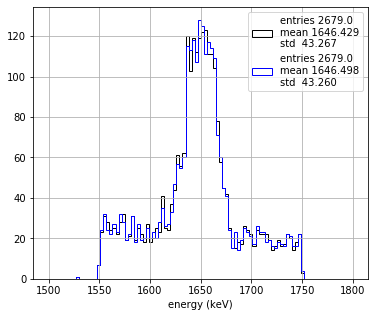

In [11]:
canvas = pltext.canvas(1, 1)
evtene = dat.groupby('event')['enec'].sum()
pltext.hist(1e3*evtene, 100, (1500, 1800));
evtene0 = dat.groupby('event')['Ec'].sum()
pltext.hist(1e3*evtene0, 100, (1500, 1800));
plt.xlabel('energy (keV)');

## Read KrMap 

In [12]:
krmap  = krana.load('krmap' , 'krmap_'+str(run)+'.h5')
xyprof = prof .load('xyprof', 'krmap_'+str(run)+'.h5')

('counts', 'eref', 'dedt', 'dtref', 'ueref', 'udedt', 'cov', 'chi2', 'pvalue', 'sigma', 'success')
('counts', 'mean', 'std', 'chi2', 'pvalue', 'success')


In [13]:
vdrift   = 0.9248098826413511
coors    = (x, y)
dtime    = z/vdrift
dat['dtime'] = dtime
ones     = np.ones(len(x))
ene      = dat.E.values
kene     = krana.krmap_scale (coors, dtime, ene  , krmap , scale = 41.5)
#kene0[np.isnan(kene0)] = 0.
#kene1    = prof.profile_scale(coors, kene0, xyprof, scale = 41.5)

In [14]:
dat['kene'] = kene
#dat['kene1'] = kene1

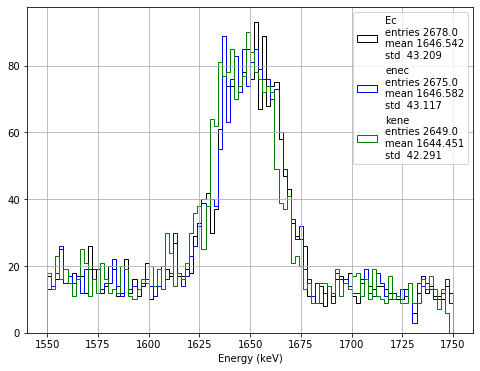

In [15]:
pltext.canvas(1, 1, 6, 8)
for name in ('Ec', 'enec', 'kene'):
    evtene = dat.groupby('event')[name].sum()
    evtene = 1e3 * evtene if name in ['Ec', 'enec'] else evtene
    pltext.hist(evtene, 100, (1550., 1750.), label = name);
plt.xlabel('Energy (keV)');

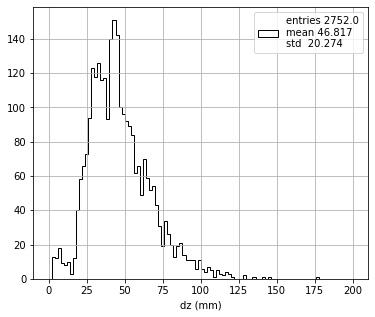

In [16]:
pltext.canvas(1, 1)
zmin = dat.groupby('event')['Z'].min()
zmax = dat.groupby('event')['Z'].max()
dz   = zmax - zmin
pltext.hist(dz, 100, (0, 200));
plt.xlabel('dz (mm)');

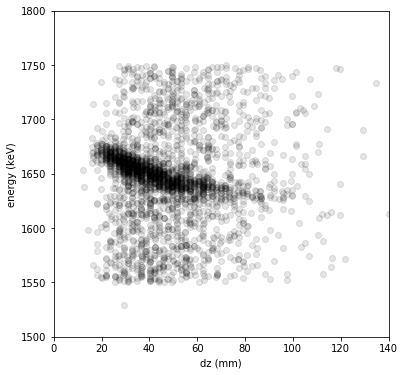

In [17]:
pltext.canvas(1, 1, 6, 6)
ene  = 1e3 * dat.groupby('event')['Ec'].sum()
zmin = dat.groupby('event')['Z'].min()
zmax = dat.groupby('event')['Z'].max()
dz   = zmax - zmin
plt.scatter(dz, ene, alpha = 0.1);
plt.xlim((0, 140)); plt.ylim((1500., 1800));
plt.xlabel('dz (mm)'); plt.ylabel('energy (keV)');

In [18]:
def get_dzprof(enename = 'Ec'):
    ene     = dat.groupby('event')[enename].sum()
    zmin    = dat.groupby('event')['Z'].min()
    zmax    = dat.groupby('event')['Z'].max()
    dz      = zmax - zmin
    sel     = np.ones(len(dz), bool)
    clean   = np.copy(sel)
    clean   = ut.in_range(dz, (0., 130))
    done    = False
    while (not done):
        dz0     = dz[clean]
        ene0    = ene[clean]
        dzprof, residuals = prof.profile((dz0,), ene0, bins = 50, counts_min = 20)
        done, usel = krana.accept_residuals(residuals, range = (-2.,2.), 
                                            fun = 'gaus+poly.1', min_sigma = 0.7)
        clean[clean == True] = usel
    return dz, ene, clean, dzprof

In [19]:
def plot_dzprof(dz, ene, sel, dzprof):
    ecor   = prof.profile_scale((dz,), ene, dzprof, 1600.)
    canvas = pltext.canvas(2, 2)
    canvas(1)
    pltext.hist(ecor[sel], 100, (1540., 1650));
    pltext.hfit(ecor[sel], 100, range = (1540., 1650.), fun = 'gaus+poly.1');
    canvas(2)
    plt.scatter(dz[sel], ecor[sel], alpha = 0.1);
    plt.xlim((0., 200));plt.ylim((1400., 1800.)); plt.xlim((0., 130));
    return

sigma 0.30 done  False  eff 74.85
sigma 0.48 done  False  eff 88.58
sigma 0.61 done  False  eff 95.55
sigma 0.68 done  False  eff 98.56
sigma 0.70 done  True  eff 100.00


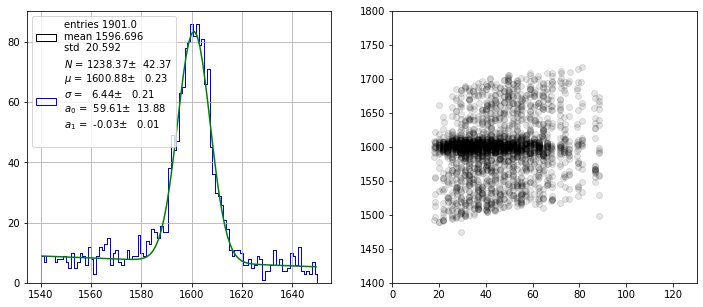

In [20]:
dz, ene, sel, dzprof = get_dzprof()
plot_dzprof(dz, ene, np.ones(len(dz), bool), dzprof)
cene = prof.profile_scale((dz,), ene, dzprof, 1600.)

sigma 0.30 done  False  eff 74.75
sigma 0.51 done  False  eff 89.78
sigma 0.62 done  False  eff 95.50
sigma 0.63 done  False  eff 96.76
sigma 0.73 done  True  eff 100.00


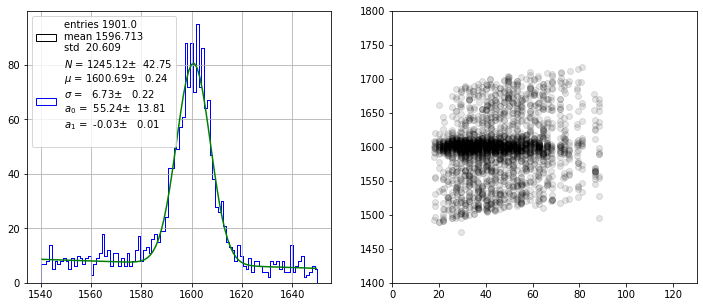

In [21]:
dz, enec, sel, dzprof = get_dzprof('enec')
plot_dzprof(dz, enec, np.ones(len(dz), bool), dzprof)
cenec = prof.profile_scale((dz,), enec, dzprof, 1600.)

sigma 0.30 done  False  eff 74.24
sigma 0.49 done  False  eff 88.82
sigma 0.60 done  False  eff 95.03
sigma 0.65 done  False  eff 97.50
sigma 0.73 done  True  eff 100.00


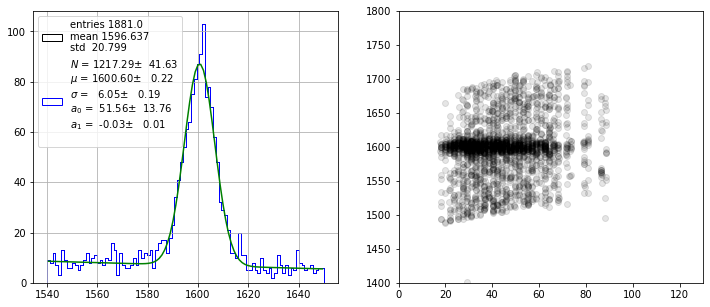

In [22]:
dz, ene0, sel, dzprof = get_dzprof('kene')
plot_dzprof(dz, ene0, np.ones(len(dz), bool), dzprof)
cene0 = prof.profile_scale((dz,), ene0, dzprof, 1600.)

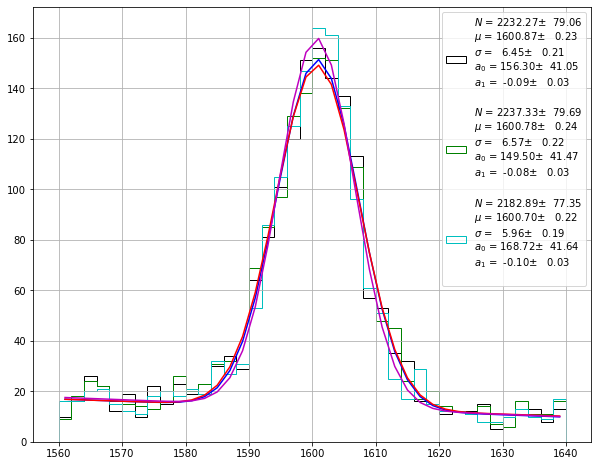

In [23]:
canvas = pltext.canvas(1, 1, 8, 10)
bins, range = 40, (1560, 1640)
pltext.hfit(cene , bins, range = range, fun = 'gaus+poly.1');
pltext.hfit(cenec, bins, range = range, fun = 'gaus+poly.1');
pltext.hfit(cene0, bins, range = range, fun = 'gaus+poly.1');

## Event study

In [24]:
xdf = {}
xdf['x'] = dat.groupby('event')['X'].mean()
xdf['y'] = dat.groupby('event')['Y'].mean()
xdf['z'] = dat.groupby('event')['Z'].mean()
xdf['dtime'] = dat.groupby('event')['dtime'].mean()
xdf['energy'] = cene0
xdf = pd.DataFrame(xdf)

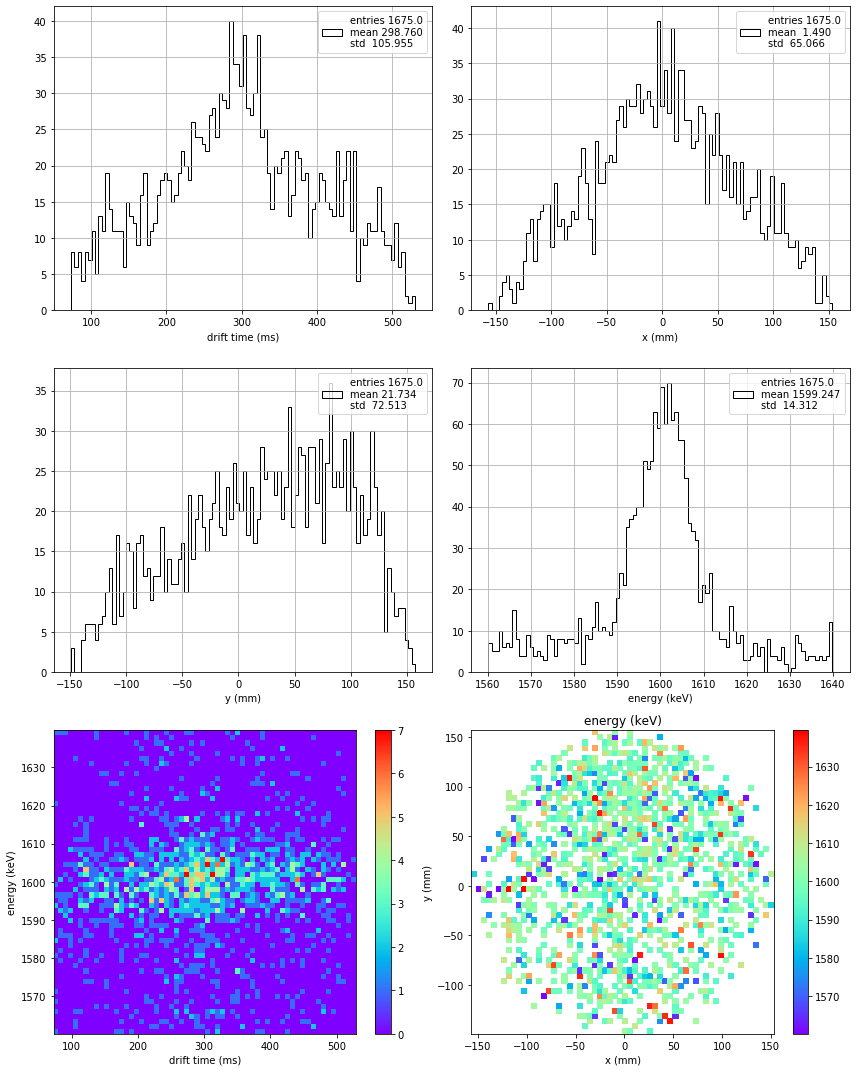

In [25]:
xsel = ut.in_range(cene0, range)
krana.plot_data(xdf[xsel], 60);

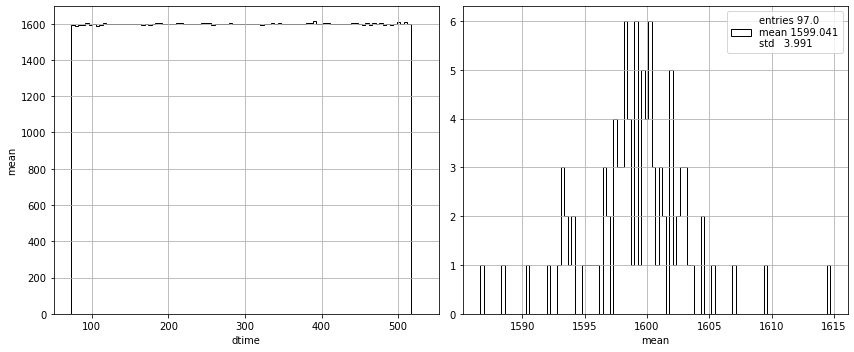

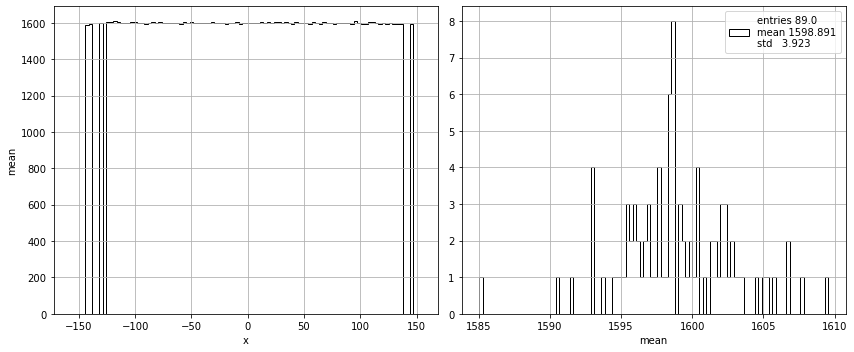

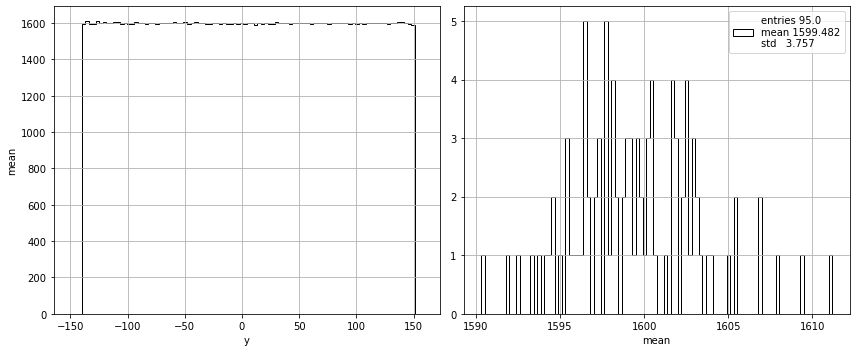

In [26]:
xsel = ut.in_range(cene0, range)
krana.plot_xydt_energy_profiles(xdf[xsel], 100);

In [27]:
xsel = (ut.in_range(xdf.dtime.values, (200, 400)))  
xsel = xsel & (ut.in_range(xdf.x.values, (-80, 80)))
xsel = xsel & (ut.in_range(xdf.y.values, (-80, 80)))

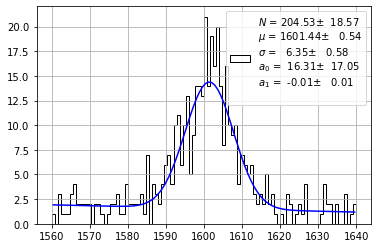

In [28]:
pltext.hfit(xdf.energy[xsel], 100, range = range, fun = 'gaus+poly.1');

In [29]:
## Cut on energy of voxels